In [ ]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


# Framework
import torch
import torchvision

# Data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image

# For creating neural networks
import torch.nn as nn
import torch.nn.functional as F

# For optimizing neural networks
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# For metrics and analysis
from sklearn.metrics import accuracy_score
from torchsummary import summary

# For dataset loading
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Setting Device for PyTorch

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cuda


In [ ]:
torch.manual_seed(42) # Setting the seed

Loading and Preprocessing the Dataset

In [ ]:
# Load the digits dataset (each image is a 64-dimensional vector, since 8x8 pixel resolution = 64 pixels)
digits = load_digits()
X, y = digits.data, digits.target
print("Data shape:", X.shape, "Labels shape:", y.shape)

# Convert target to one-hot encoding
# One-hot encoding transforms each label into a binary vector where only the index corresponding to the digit is 1, and the rest are 0
# y = 3  →  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
# sparse_output=False: Ensures the output is a dense array instead of a sparse matrix.
encoder = OneHotEncoder(sparse_output=False)
# y.reshape(-1, 1): Reshapes y from (1797,) to (1797, 1), as OneHotEncoder expects a 2D array.
# encoder.fit_transform(y.reshape(-1, 1)): Applies one-hot encoding to y
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training, validation, and test sets (70%-15%-15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Data shape: (1797, 64) Labels shape: (1797,)
Training data shape: (1257, 64)
Validation data shape: (270, 64)
Test data shape: (270, 64)


In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Conversion to Torch Tensors

In [ ]:
# Convert to torch tensors because PyTorch's deep learning models and operations require tensors as inputs.
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

*Creating* DataLoaders

In [ ]:
# Create TensorDatasets for training, validation, and testing data
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Define batch size
batch_size = 32

# Create DataLoaders for training, validation, and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network with 3 hidden layers

In [ ]:
# Define the fully connected neural network
class DigitsNet(nn.Module):
    def __init__(self):
        super(DigitsNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)  # Hidden layer 1
        self.fc2 = nn.Linear(128, 64)          # Hidden layer 2
        self.fc3 = nn.Linear(64, 32)           # Hidden layer 3
        self.fc4 = nn.Linear(32, 10)           # Output layer (10 classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on output layer for logits
        return x

In [ ]:
# Create an instance of the network
net = DigitsNet()
net = net.to(device)

# Print the neural network's architecture
print(net)

DigitsNet(
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
for name, param in net.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter fc1.weight, shape torch.Size([128, 64])
Parameter fc1.bias, shape torch.Size([128])
Parameter fc2.weight, shape torch.Size([64, 128])
Parameter fc2.bias, shape torch.Size([64])
Parameter fc3.weight, shape torch.Size([32, 64])
Parameter fc3.bias, shape torch.Size([32])
Parameter fc4.weight, shape torch.Size([10, 32])
Parameter fc4.bias, shape torch.Size([10])


In [ ]:
summary(net, input_size=(64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           8,320
            Linear-2                   [-1, 64]           8,256
            Linear-3                   [-1, 32]           2,080
            Linear-4                   [-1, 10]             330
Total params: 18,986
Trainable params: 18,986
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


#Custom Gradient Descent with Momentum


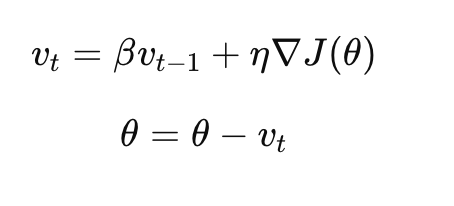

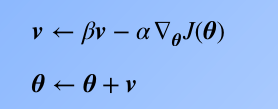

In [ ]:
import torch
from torch.optim import Optimizer

class MomentumOptimizer(Optimizer):
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        # Stores default hyperparameters (lr and momentum).
        defaults = {'lr': lr, 'momentum': momentum}
        super().__init__(parameters, defaults)
        # self.param_groups: Stores groups of parameters.
        # {id(p): torch.zeros_like(p)}: Creates a dictionary where: Keys: id(p) (unique identifier for each parameter).
        # Values: torch.zeros_like(p) (same shape as p, initialized to zero).
        # This initializes momentum velocity to zero for each parameter.
        self.velocities = {id(p): torch.zeros_like(p) for group in self.param_groups for p in group['params']}

    def step(self, closure=None):
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    # v = self.velocities[id(p)]: Retrieves the momentum term for parameter p.
                    v = self.velocities[id(p)]
                    # v.mul_(group['momentum']): Multiplies v by momentum coefficient 𝛽 (in-place update).
                    # .add_(p.grad, alpha=group['lr']): Adds gradient scaled by learning rate.
                    v.mul_(group['momentum']).add_(p.grad, alpha=group['lr'])
                    # p.sub_(v): Updates the parameter using momentum gradient descent:
                    p.sub_(v)

    def zero_grad(self):
      # This function clears gradients before the next update to avoid incorrect updates.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score
lr_history = []
def train_and_evaluate_regression(model, learning_rate, trainloader,valloader, testloader, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = MomentumOptimizer(model.parameters(), lr=learning_rate, momentum=0.9)
    # A learning rate scheduler that reduces the learning rate when the validation loss stagnates.
    # Monitors the validation loss (mode='min').
    # Reduces learning rate by a factor of 0.1 if validation loss doesn’t improve for 3 epochs (patience=3).
    # verbose=True: Prints learning rate updates.
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


    # Lists for saving history
    train_loss_history = []
    val_loss_history = []
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        # Tracks total training samples.
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            # optimizer.zero_grad(): Clears gradients before the next step.
            optimizer.zero_grad()
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, torch.argmax(labels, dim=1)) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            # loss.item() = 0.5 (the average loss for all 32 samples in the batch), then the total loss for this batch is 0.5 * 32 = 16.0
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0
        # torch.no_grad(): Disables gradient computation for faster inference.
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == torch.argmax(labels, dim=1)).sum().item()

        val_loss /= total
        val_loss_history.append(val_loss)
        val_accuracy = correct / total

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate if needed
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            # If the validation loss does not improve for 10 consecutive epochs, training stops early.
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    #  Final Model Evaluation on Test Data
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
            total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    test_accuracy = correct / total
    test_f1 = f1_score(all_labels, all_preds, average="weighted")

    return train_loss_history, val_loss_history, test_accuracy, test_f1


In [ ]:
# Initialize the model
net = DigitsNet()
net = net.to(device)
# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results1 = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_loss, val_loss, test_accuracy, test_f1 = train_and_evaluate_regression(net, lr, trainloader, valloader, testloader)
    results1[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
        }

Training with learning rate: 0.01


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 2.2803, Validation Loss: 2.2415
Updated learning rate after epoch 1: 0.010000
Epoch [2/30], Train Loss: 2.1439, Validation Loss: 1.9852
Updated learning rate after epoch 2: 0.010000
Epoch [3/30], Train Loss: 1.5782, Validation Loss: 1.1260
Updated learning rate after epoch 3: 0.010000
Epoch [4/30], Train Loss: 0.7261, Validation Loss: 0.4910
Updated learning rate after epoch 4: 0.010000
Epoch [5/30], Train Loss: 0.3242, Validation Loss: 0.2707
Updated learning rate after epoch 5: 0.010000
Epoch [6/30], Train Loss: 0.1734, Validation Loss: 0.1828
Updated learning rate after epoch 6: 0.010000
Epoch [7/30], Train Loss: 0.1188, Validation Loss: 0.1436
Updated learning rate after epoch 7: 0.010000
Epoch [8/30], Train Loss: 0.0803, Validation Loss: 0.1286
Updated learning rate after epoch 8: 0.010000
Epoch [9/30], Train Loss: 0.0600, Validation Loss: 0.1190
Updated learning rate after epoch 9: 0.010000
Epoch [10/30], Train Loss: 0.0406, Validation Loss: 0.0924
Updat

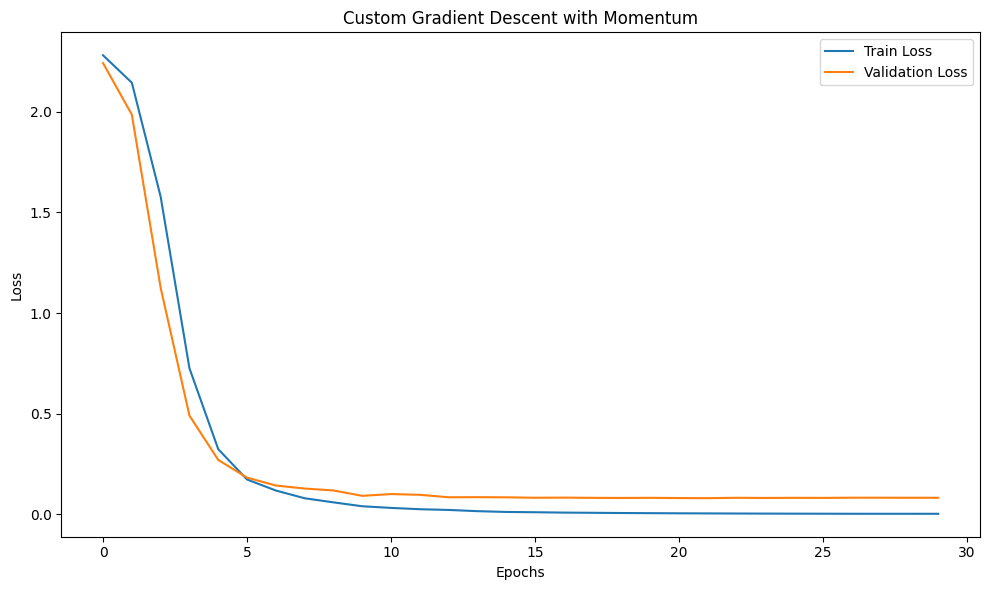

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('Custom Gradient Descent with Momentum')

for lr, result in results1.items():
    plt.plot(result['train_loss'], label=f'Train Loss')
    plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


#Pytorch SGD with Momentum


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_history = []
def train_and_evaluate_regression(model, learning_rate, trainloader,valloader, testloader, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, torch.argmax(labels, dim=1)) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == torch.argmax(labels, dim=1)).sum().item()

        val_loss /= total
        val_loss_history.append(val_loss)
        val_accuracy = correct / total

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
            total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    test_accuracy = correct / total
    test_f1 = f1_score(all_labels, all_preds, average="weighted")

    return train_loss_history, val_loss_history, test_accuracy, test_f1

In [ ]:
# Initialize the model
net = DigitsNet()
net = net.to(device)
# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results2 = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_loss, val_loss, test_accuracy, test_f1 = train_and_evaluate_regression(net, lr, trainloader, valloader, testloader)
    results2[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
        }

Training with learning rate: 0.01
Epoch [1/30], Train Loss: 2.2751, Validation Loss: 2.2291
Updated learning rate after epoch 1: 0.010000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [2/30], Train Loss: 2.1381, Validation Loss: 1.9667
Updated learning rate after epoch 2: 0.010000
Epoch [3/30], Train Loss: 1.6485, Validation Loss: 1.1973
Updated learning rate after epoch 3: 0.010000
Epoch [4/30], Train Loss: 0.8464, Validation Loss: 0.5394
Updated learning rate after epoch 4: 0.010000
Epoch [5/30], Train Loss: 0.3844, Validation Loss: 0.3326
Updated learning rate after epoch 5: 0.010000
Epoch [6/30], Train Loss: 0.1966, Validation Loss: 0.2079
Updated learning rate after epoch 6: 0.010000
Epoch [7/30], Train Loss: 0.1192, Validation Loss: 0.1786
Updated learning rate after epoch 7: 0.010000
Epoch [8/30], Train Loss: 0.0845, Validation Loss: 0.1604
Updated learning rate after epoch 8: 0.010000
Epoch [9/30], Train Loss: 0.0598, Validation Loss: 0.1333
Updated learning rate after epoch 9: 0.010000
Epoch [10/30], Train Loss: 0.0435, Validation Loss: 0.1398
Updated learning rate after epoch 10: 0.010000
Epoch [11/30], Train Loss: 0.0337, Validation Loss: 0.1226
Upd

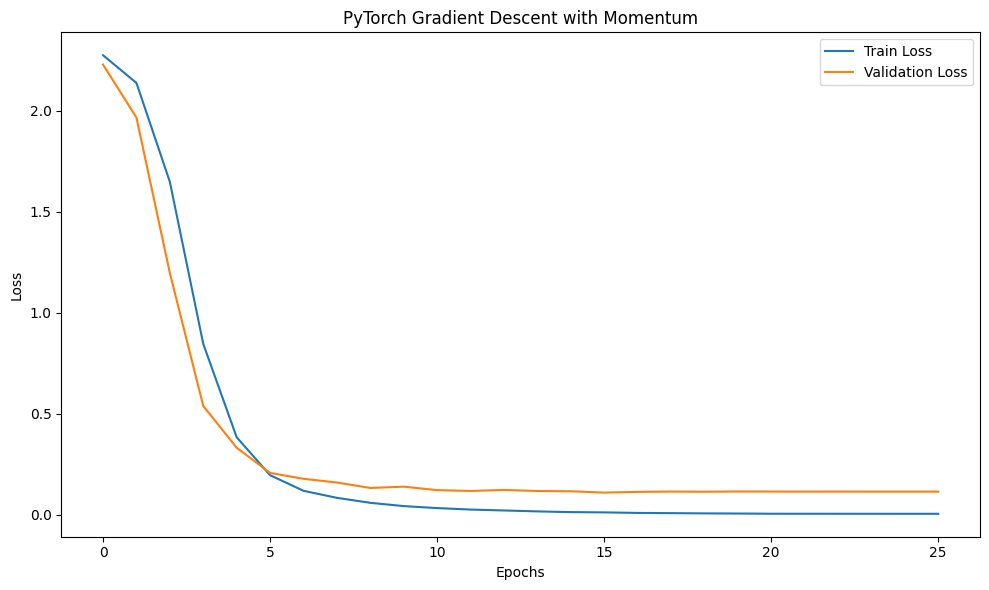

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('PyTorch Gradient Descent with Momentum')

for lr, result in results2.items():
    plt.plot(result['train_loss'], label=f'Train Loss')
    plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


#Comparison of Both

In [ ]:
print(f"Custom Gradient Descent with Momentum Test Accuracy: {results1[0.01]['test_accuracy']:.4f}, f1: {results1[0.01]['test_f1']:.4f}")
print(f"PyTorch Gradient Descent with Momentum Test Accuracy: {results2[0.01]['test_accuracy']:.4f}, f1: {results2[0.01]['test_f1']:.4f}")


Custom Gradient Descent with Momentum Test Accuracy: 0.9704, f1: 0.9702
PyTorch Gradient Descent with Momentum Test Accuracy: 0.9778, f1: 0.9777


#Custom RMS Prop

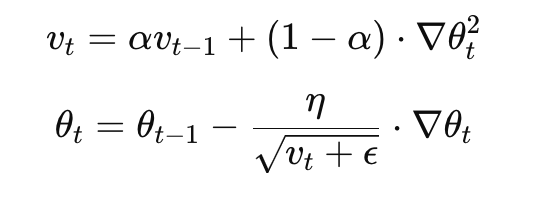

In [ ]:
from torch.optim import Optimizer
lr_history = []
class RMSpropOptimizer(Optimizer):
    def __init__(self, parameters, lr=0.01, alpha=0.9, epsilon=1e-10):
      #Intialize the default parameters
        defaults = {
            'lr': lr,
            'alpha': alpha,
            'epsilon': epsilon
        }
        super().__init__(parameters, defaults)

    def step(self, closure=None):
        with torch.no_grad():
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        # Retrieve optimizer-specific parameters
                        alpha = group['alpha']
                        epsilon = group['epsilon']
                        lr = group['lr']

                        # Initialize state for this parameter if not already done
                        state = self.state[p]
                        if 'squared_gradient' not in state:
                            state['squared_gradient'] = torch.zeros_like(p)

                        # Update squared gradient
                        squared_gradient = state['squared_gradient']
                        squared_gradient.mul_(alpha).add_(p.grad ** 2 * (1 - alpha))

                        # Compute adjusted learning rate and update parameter
                        adjusted_lr = lr / (torch.sqrt(squared_gradient + epsilon))
                        p.sub_(p.grad * adjusted_lr)
    # After each step, we set all the gradients to zero, preparing for the next backpropagation pass.
    def zero_grad(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.zero_()


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_history = []
def train_and_evaluate_regression(model, learning_rate, trainloader,valloader, testloader, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = RMSpropOptimizer(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, torch.argmax(labels, dim=1)) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == torch.argmax(labels, dim=1)).sum().item()

        val_loss /= total
        val_loss_history.append(val_loss)
        val_accuracy = correct / total

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
            total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    test_accuracy = correct / total
    test_f1 = f1_score(all_labels, all_preds, average="weighted")

    return train_loss_history, val_loss_history, test_accuracy, test_f1

In [ ]:
# Initialize the model
net = DigitsNet()
net = net.to(device)
# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results3 = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_loss, val_loss, test_accuracy, test_f1 = train_and_evaluate_regression(net, lr, trainloader, valloader, testloader)
    results3[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
        }

Training with learning rate: 0.01


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 0.7359, Validation Loss: 0.2131
Updated learning rate after epoch 1: 0.010000
Epoch [2/30], Train Loss: 0.1803, Validation Loss: 0.1684
Updated learning rate after epoch 2: 0.010000
Epoch [3/30], Train Loss: 0.1089, Validation Loss: 0.2951
Updated learning rate after epoch 3: 0.010000
Epoch [4/30], Train Loss: 0.0813, Validation Loss: 0.1614
Updated learning rate after epoch 4: 0.010000
Epoch [5/30], Train Loss: 0.0766, Validation Loss: 0.1017
Updated learning rate after epoch 5: 0.010000
Epoch [6/30], Train Loss: 0.0567, Validation Loss: 0.4070
Updated learning rate after epoch 6: 0.010000
Epoch [7/30], Train Loss: 0.0630, Validation Loss: 0.1229
Updated learning rate after epoch 7: 0.010000
Epoch [8/30], Train Loss: 0.0285, Validation Loss: 0.1485
Updated learning rate after epoch 8: 0.010000
Epoch [9/30], Train Loss: 0.0669, Validation Loss: 0.1583
Updated learning rate after epoch 9: 0.001000
Epoch [10/30], Train Loss: 0.0091, Validation Loss: 0.1030
Updat

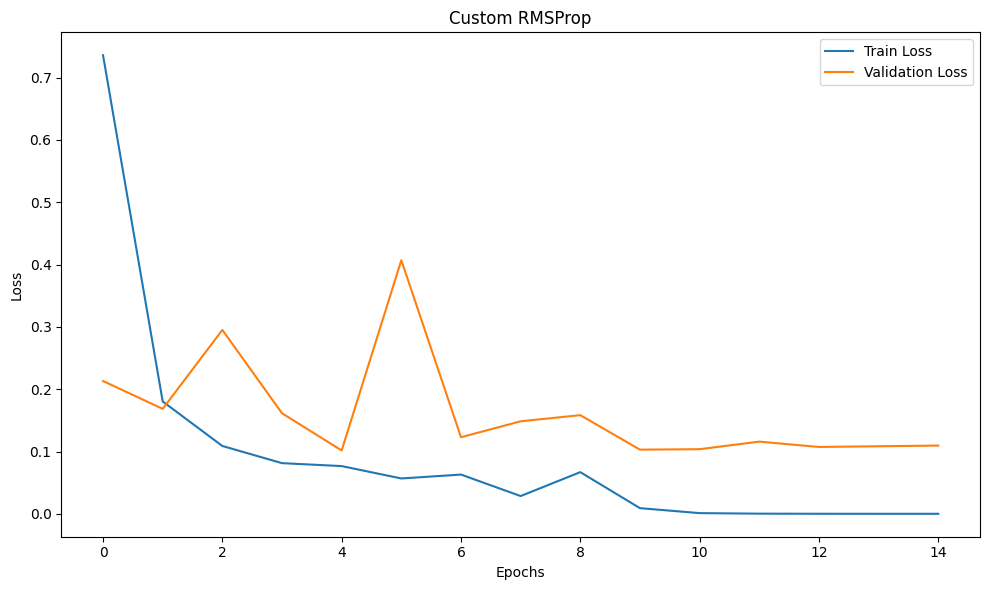

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('Custom RMSProp')

for lr, result in results3.items():
    plt.plot(result['train_loss'], label=f'Train Loss')
    plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


#Pytorch RMSProp

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_history = []
def train_and_evaluate_regression(model, learning_rate, trainloader,valloader, testloader, epochs=30, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Lists for saving history
    train_loss_history = []
    val_loss_history = []

    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        total = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Ensure labels are the correct shape
            optimizer.zero_grad()  # Zeroing the Gradients
            outputs = model(inputs) # Forward Pass
            loss = criterion(outputs, torch.argmax(labels, dim=1)) # Computing the Loss
            loss.backward() # Backward Pass
            optimizer.step() # Updating the Model Parameters
            running_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

        train_loss = running_loss / total
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        total = 0
        correct = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, torch.argmax(labels, dim=1))
                val_loss += loss.item() * inputs.size(0)
                total += inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == torch.argmax(labels, dim=1)).sum().item()

        val_loss /= total
        val_loss_history.append(val_loss)
        val_accuracy = correct / total

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)  # Update the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Updated learning rate after epoch {epoch+1}: {current_lr:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == torch.argmax(labels, dim=1)).sum().item()
            total += inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    test_accuracy = correct / total
    test_f1 = f1_score(all_labels, all_preds, average="weighted")

    return train_loss_history, val_loss_history, test_accuracy, test_f1

In [ ]:
# Initialize the model
net = DigitsNet()
net = net.to(device)
# Define learning rates to test
learning_rates = [0.01]

# Placeholder for results
results4 = {}

# Train the model with different learning rates and store the results
for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_loss, val_loss, test_accuracy, test_f1 = train_and_evaluate_regression(net, lr, trainloader, valloader, testloader)
    results4[lr] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1
        }

Training with learning rate: 0.01
Epoch [1/30], Train Loss: 1.4006, Validation Loss: 0.3260
Updated learning rate after epoch 1: 0.010000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [2/30], Train Loss: 0.2395, Validation Loss: 0.2213
Updated learning rate after epoch 2: 0.010000
Epoch [3/30], Train Loss: 0.1628, Validation Loss: 0.2368
Updated learning rate after epoch 3: 0.010000
Epoch [4/30], Train Loss: 0.0799, Validation Loss: 0.1798
Updated learning rate after epoch 4: 0.010000
Epoch [5/30], Train Loss: 0.0408, Validation Loss: 0.1373
Updated learning rate after epoch 5: 0.010000
Epoch [6/30], Train Loss: 0.0367, Validation Loss: 0.1178
Updated learning rate after epoch 6: 0.010000
Epoch [7/30], Train Loss: 0.0456, Validation Loss: 0.0986
Updated learning rate after epoch 7: 0.010000
Epoch [8/30], Train Loss: 0.0174, Validation Loss: 0.1037
Updated learning rate after epoch 8: 0.010000
Epoch [9/30], Train Loss: 0.0141, Validation Loss: 0.1554
Updated learning rate after epoch 9: 0.010000
Epoch [10/30], Train Loss: 0.1056, Validation Loss: 0.4204
Updated learning rate after epoch 10: 0.010000
Epoch [11/30], Train Loss: 0.1200, Validation Loss: 0.2269
Upd

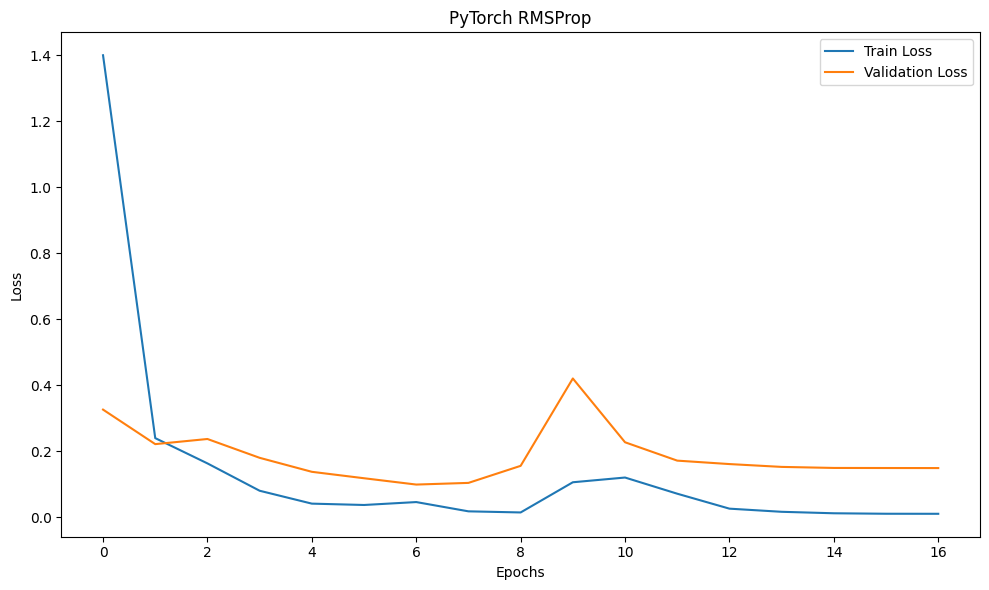

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.title('PyTorch RMSProp')

for lr, result in results4.items():
    plt.plot(result['train_loss'], label=f'Train Loss')
    plt.plot(result['val_loss'], label=f'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


#Comparison of both

In [ ]:
print(f"Custom RMSProp Test Accuracy: {results3[0.01]['test_accuracy']:.4f}, f1: {results3[0.01]['test_f1']:.4f}")
print(f"PyTorch RMSProp Test Accuracy: {results4[0.01]['test_accuracy']:.4f}, f1: {results4[0.01]['test_f1']:.4f}")

Custom RMSProp Test Accuracy: 0.9852, f1: 0.9852
PyTorch RMSProp Test Accuracy: 0.9593, f1: 0.9593


# Assignment 4 - Gradient Descent Algorithms – January 28 (Total Marks = 20)

# 1) Load and preprocess the Bike Sharing dataset from https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset – check for missing and duplicate values and remove them when detected (set encoding='latin-1' while reading dataset otherwise it will throw error). Drop the columns which you think won't effect ouput and one-hot encode the categorical features (1 MARKS)
# 2) Divide the data into training, validation and test sets (70%-15%-15%) and perform feature scaling (2 MARKS)
# 3) Design a neural network having N=4 hidden layers and the number of units in each hidden layer as 128, 64, 32, 16. Use the ReLU activation function in each hidden layer. What activation function should you choose for the output layer for this prediction problem? Design the model accordingly. (2 MARKS)
# 4) Implement the Adam optimizer from scratch to train the above model. (6 MARKS)
# 5) Train the model with the custom implementation of Adam and plot the training and validation losses (2 MARKS)
# 6) report the MSE and $R^2$ score obtained by the trained model on the test (2 MARKS)
# 7) Show a scatter plot of the predictions against the true values for the predictions for the best model that you obtained (1 MARK)
# 8) Train the same model using PyTorch’s Adam optimizer, and show the same loss plots for training and validation losses. (2 MARKS)
# 9) Perform inference on the test set using the model trained with PyTorch’s implementation of the Adam optimizer. Report the MSE and $R^2$ score on the test set and show the scatter plot of predictions vs. ground truths. Compare the $R^2$  score obtained using the PyTorch implementation of Adam with your from scratch implementation. (3 MARKS)

